# VARIACIÓN DE LA FRECUENCIA CARDÍACA



*Autor: Paula Bonomini*

SIM 2022Q2


Fuente: https://physionet.org/content/mitdb/1.0.0/

Monto el drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importo librerías que voy a utilizar:

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.signal as sg

In [3]:
# Instalo librerias utiles

! pip install wfdb # https://github.com/MIT-LCP/wfdb-python
# https://wfdb.readthedocs.io/en/latest/

import wfdb 
from wfdb import processing 

! pip install pyhrv # https://pypi.org/project/pyhrv/
import pyhrv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##  HRV

Representaciones

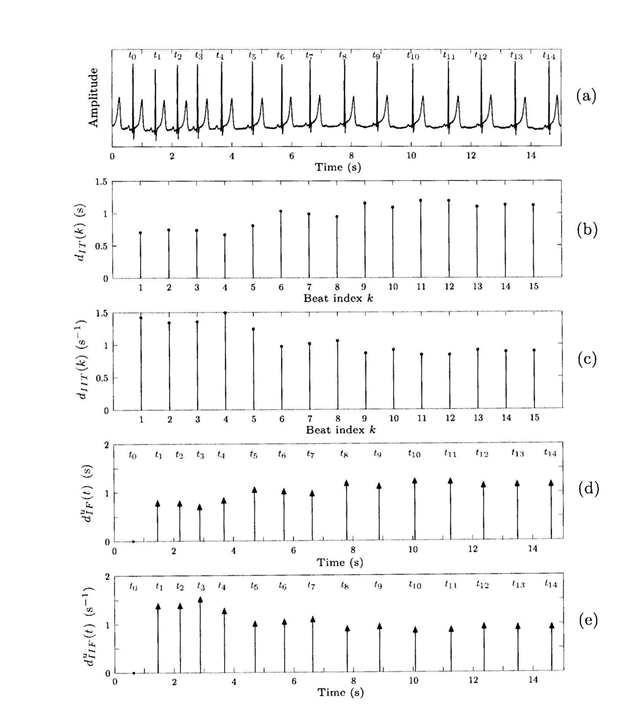

# Tacograma

No hay una representación temporal. No puedo aplicar sobre esta sucesión ninguna técnica de procesamiento de señales. Solo puedo medir la dispersión de los intervalos RR con métricas estadísticas. Esta representación es utilizada en el ***Análisis temporal de la Variabilidad de la Frecuencia Cardíaca***

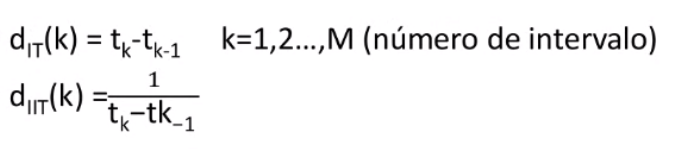

## Función Intervalo

Tengo una representación temporal, pero aún así las muestras no están equiespaciadas. Ergo, no puedo hacer un análisis de Fourier sobre esta serie. No obstante, si puedo hacer análisis espectral, mediante el ***Periodograma de Lomb***, que es una versión de Fourier adapatado a señales con muestreo no equiespaciado.  
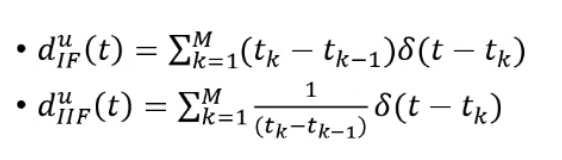

## Interpolación de orden cero

Con esta función tengo muestras equiespaciadas en el tiempo. Sobre esta representación puedo hacer un análisis clásico de Fourier.
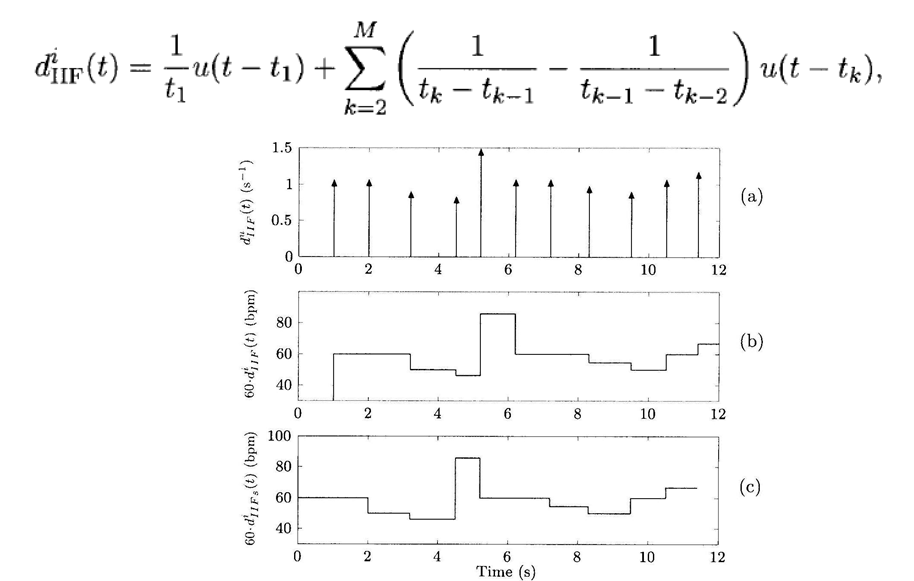

## Librerías en internet

## [wfdb](https://wfdb.readthedocs.io/en/latest/index.html)

In [4]:
# CARGO ARCHIVO 
# path = '/content/drive/MyDrive/SIM2022Q2/señales/mitdb/105'
path = '/content/drive/MyDrive/SIM2022Q2/señales/mitdb/104'
# path = '/content/drive/MyDrive/Colab Notebooks/Práctica SIM/señales/mitdb/109'
N = 15000
signal, fields = wfdb.io.rdsamp(path, 0, N)


In [5]:
# CHEQUEAMOS FIELDS
print(type(fields))
print(fields['fs'], fields['sig_name'])


<class 'dict'>
360 ['V5', 'V2']


(15000, 2)


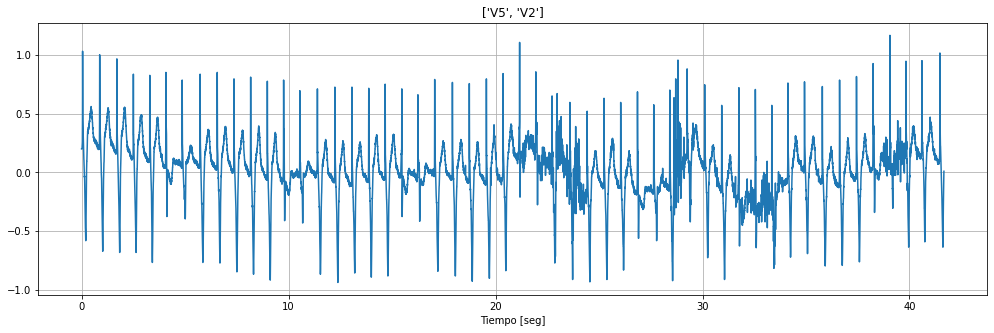

In [6]:
# cargo signal y fs
print(signal.shape)

x = signal[:,1]
fs = fields['fs']
t = np.arange(0,x.size)/fs 
plt.figure(figsize=(17,5))
plt.plot(t,x)
plt.xlabel('Tiempo [seg]')
plt.title(fields['sig_name'])
plt.grid(True)


In [7]:
# Leo anotaciones
ann = wfdb.io.rdann(path, 'atr', sampfrom=0, sampto=N, return_label_elements=['symbol', 'description'])
# ann1 = wfdb.Annotation(record_name=path, extension='atr')

In [8]:
# Muestra los tipos de anotaciones
wfdb.io.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed QRS detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [9]:
# muestra las etiquetas estándar
wfdb.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [10]:
# detecto anormales
sample_anotaciones = ann.sample
labels_anotaciones = ann.symbol
# Chequeamos largo
if len(labels_anotaciones) != len(sample_anotaciones):
  raise ("ERRRRRRRRRRRRRORRRRRRRRRRRRRRRRRRRRRR")

anormalidades = list()
for (label, sample) in zip(labels_anotaciones, sample_anotaciones):
  if label != 'N':
    anormalidades.append((sample, label))    

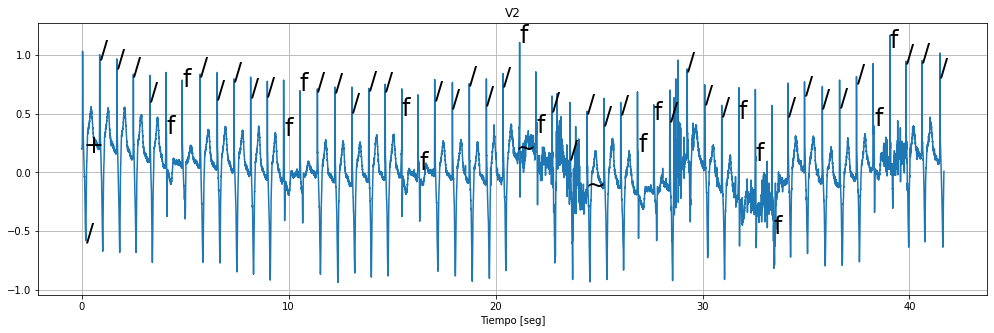

In [11]:
# cargo signal y fs
x = signal[:,1]
fs = fields['fs']
t = np.arange(0,x.size)/fs 
plt.figure(figsize=(17,5))
plt.plot(t, x)

for (sample, label) in anormalidades:
  # plt.plot(sample/fs, x[sample], '*k')
  plt.text(sample/fs, x[sample], label, fontsize=24)

plt.xlabel('Tiempo [seg]')
plt.title(fields['sig_name'][1])
# plt.xlim(36, 40)
plt.grid(True)

In [12]:
# Detector QRS wfdb.processing
qrs_detected = wfdb.processing.xqrs_detect(x, fs)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Comparo gráficamente la salida de mi detector y las anotaciones

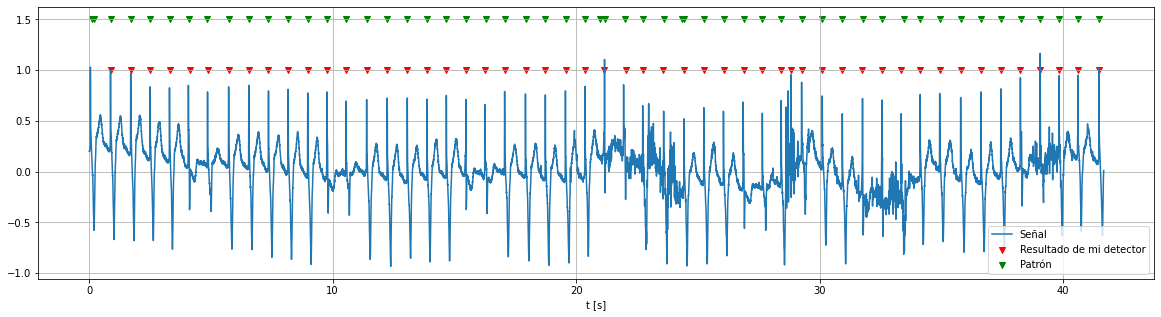

In [13]:
plt.figure(figsize=(20,5))
plt.plot(t, x, label = 'Señal')

plt.scatter(qrs_detected/fs, 1*np.ones(len(qrs_detected)), label='Resultado de mi detector',marker='v',color='r')
plt.scatter(sample_anotaciones/fs, 1.5*np.ones(len(sample_anotaciones)), label='Patrón',marker='v',color='g')
plt.xlabel('t [s]')
plt.legend(loc='lower right')
#plt.title(fields['sig_name'][1])
# plt.xlim(36, 40)
plt.grid(True)

# Construimos y corregimos el tacograma 

[0.40985839]
[0.38611111]


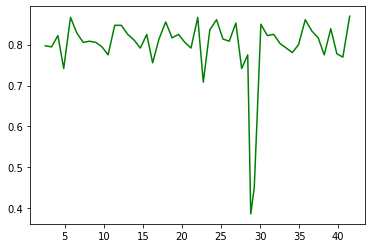

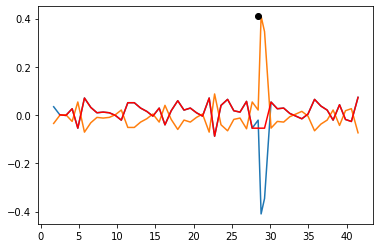

In [14]:
# Hecho por Paula
# Construimos y Graficamos el tacograma 
# tdk1 es la serie RR
# tdk2 es la serie NN

dk_detector = np.diff(qrs_detected) # Serie de Intervalos RR en muestras
tdk1 = dk_detector /fs                # Serie de Intervalos RR en segundos
plt.plot(qrs_detected[2:]/fs, tdk1[1:], 'green')

# Corrección Tacograma
tdk2 = tdk1.copy()
s = tdk1-np.mean(tdk1)
plt.figure()
plt.plot(qrs_detected[1:]/fs, s)
picos = sg.find_peaks(s, height = 0.25)
if picos[0].shape == (0,):
  picos = sg.find_peaks(-s, height = 0.25)
  plt.plot(qrs_detected[1:]/fs, -s)

# picos[0].shape = abs(picos[0].shape) # REVISAR
# picos = abs(sg.find_peaks(-s, height = 0.25)) # REVISAR
# plt.plot(qrs_detected[1:]/fs, -s) # REVISAR

type(picos[1])
print(picos[1]['peak_heights'])
print(tdk1[picos[0]])
plt.plot(qrs_detected[picos[0]]/fs, picos[1]['peak_heights'], 'ko')
tdk2[picos[0]] = tdk2[picos[0]-2]
tdk2[picos[0]-1] = tdk2[picos[0]-2]
tdk2[picos[0]+1] = tdk2[picos[0]-2]
plt.plot(qrs_detected[2:]/fs, tdk2[1:]-np.mean(tdk1), 'red')

# Analisis de Fourier Clásico - 

Comparo diferencias entre la serie RR y la serie NN


# Interpolación orden 0 y resampleo a 4Hz

---



In [15]:
# DEFINO FUNCION RESAMPLEO




# Hold and sample  #################

####################################
# Grafico serie, tNN y nn2, tnn2 para chequear que funciona el hold and sample


# Aplico antialias a 2 Hz a nn2


# Resampleo a 4 Hz la version con el antialias de nn2



14930 14930
360
51 51
14930 14930


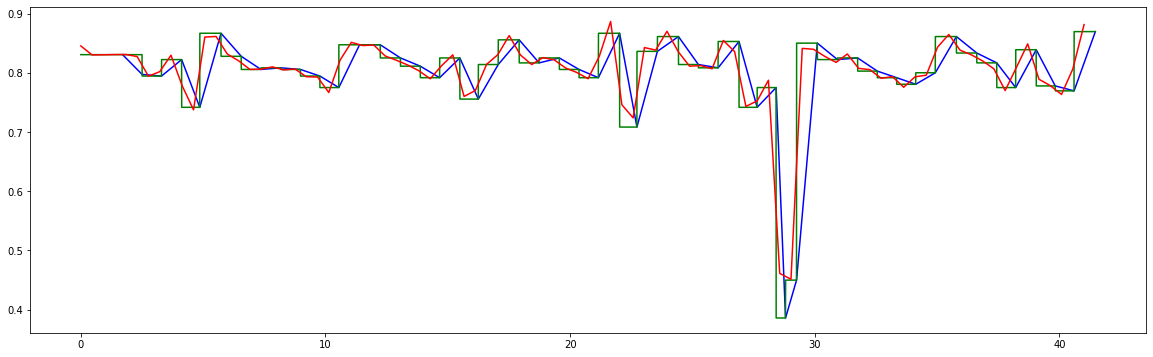

In [16]:
# DEFINO FUNCION RESAMPLEO
# Utilizo series NN y tNN
# El resultado es tnn2 [seg] y nn2 [seg]
def resampleo_orden_cero(nn, tnn, fs):
  tnn2 = np.arange(0, tnn[-1]/fs, 1/fs)
  nn2 = np.zeros_like(tnn2)
  print(tnn2.size, tnn[-1])
  print(fs)

  samp = nn[0]
  j = 1
  for i in range(0, tnn2.size):
    if (i == tnn[j]) and (j < nn.size):
      j = j + 1
      samp = nn[j]
    nn2[i] = samp
    
  return nn2, tnn2

# Trabajo con tdk1 y tdk2 y veo diferencias
serie = tdk1
# serie = tdk2
fs2 = 4
tNN = qrs_detected[1:]

# Hold and sample  #################

nn2, tnn2 = resampleo_orden_cero(serie, tNN, fs) # tdk en segundos, tNN en muestras
# Considerar que tnn2 y nn2 en segundos
####################################
# Grafico serie, tNN y nn2, tnn2 para chequear que funciona el hold and sample
plt.figure(figsize = (20, 6))
print(tNN.size, serie.size)
plt.plot(tNN/fs, serie[:], 'b')
print(tnn2.size, nn2.size)
plt.plot(tnn2, nn2, 'g')

# Aplico antialias a 2 Hz
b,a = sg.butter(4, 2, fs=fs)
nn2_lp = sg.filtfilt(b,a,nn2)

# Resampleo a 4 Hz
nn2_4Hz, tnn2_4Hz = sg.resample(nn2_lp, fs//fs2, tnn2)
plt.plot(tnn2_4Hz, nn2_4Hz, 'r')


(0.0, 2.0)

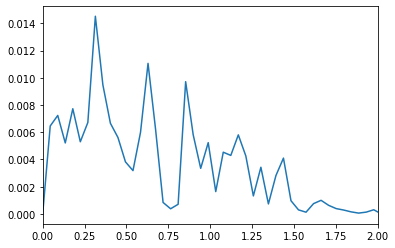

In [17]:
# Calculamos Fourier clásico sobre señal equimuestreada a 4 Hz
# Comparamos los periodogramas de la serie RR y la serie NN
S_NN = np.abs(np.fft.fft(nn2_4Hz-np.mean(nn2_4Hz)))**2 / nn2_4Hz.size
w = np.linspace(0, fs2, nn2_4Hz.size)

plt.plot(w,S_NN)
plt.xlim([0, fs2//2])
